# Micropillar Dual-Mode Image Analysis Pipeline (Pillar U-Net + C2 Quantification)

This single notebook is intended for **public reproducibility** (e.g., a GitHub repo for reviewers).
It:

1. **Downloads** the trained pillar-segmentation model from Box (if missing)
2. Runs **U-Net inference** on **C1** images to create pillar masks
3. Uses pillar masks to quantify **birefringent CaCO₃** signal in **C2** images
4. Exports **per-image metrics** and **condition-aggregated summaries** as CSV

**Expected naming convention (recommended):**  
`<channel>.<section>.<diameter>.<trial>.c1.png` and `...c2.png`  
Example: `t1.1.8.a.c1.png` and `t1.1.8.a.c2.png`

If your filenames differ, update `parse_filename()` and `pair_c1_c2()`.


### Optional: install dependencies (Colab)

If you're running in Google Colab, uncomment and run the install cell below.


In [1]:
# Install dependencies (Colab / fresh environments)
!pip -q install segmentation-models-pytorch albumentations opencv-python tqdm pandas matplotlib requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.8 MB/s eta 0:00:00


Cloning repo into Colab...
Cloning into 'micropillar-precipitation-segmentation'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 112 (delta 37), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 64.95 MiB | 25.26 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Working directory: /content/micropillar-precipitation-segmentation
Checking for images folder: /content/micropillar-precipitation-segmentation/test_images

Contents of test_images (first 30):
total 39M
drwxr-xr-x 2 root root 4.0K Jan 15 04:00 .
drwxr-xr-x 6 root root 4.0K Jan 15 04:00 ..
-rw-r--r-- 1 root root    1 Jan 15 04:00 README.MD
-rw-r--r-- 1 root root 4.0M Jan 15 04:00 s1.1.6.b.c1.png
-rw-r--r-- 1 root root 2.7M Jan 15 04:00 s1.1.6.b.c2.png
-rw-r--r-- 1 root root 4.3M Jan 15 04:00 s1.2.6.c.c1.png
-rw-r--r-- 1 root root 3.1M Jan 15 04:00 s1.2.6.c.c2.png
-rw-r--r-- 1 root root 4.1M Jan 

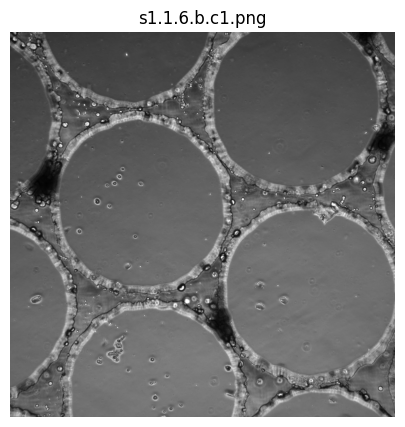

In [2]:
# =======================
# Step 1: Clone GitHub repo into Colab
# =======================

from pathlib import Path
import os
import matplotlib.pyplot as plt
import cv2

# Set your repo URL (leave as-is if correct)
REPO_URL = "https://github.com/d-ericksonlab/micropillar-precipitation-segmentation.git"

REPO_NAME = REPO_URL.rstrip("/").split("/")[-1].replace(".git", "")
REPO_PATH = Path("/content") / REPO_NAME

# Clone only if missing
if not REPO_PATH.exists():
    print("Cloning repo into Colab...")
    !git clone {REPO_URL}
else:
    print("Repo already exists in Colab")

# Move into repo
os.chdir(REPO_PATH)
print("Working directory:", Path.cwd())

# Confirm test images folder exists
IMG_DIR = Path("test_images")
print("Checking for images folder:", IMG_DIR.resolve())

if not IMG_DIR.exists():
    raise FileNotFoundError(
        f"Could not find {IMG_DIR.resolve()}.\n\n"
        f"Fix: confirm test images are committed to GitHub under: {IMG_DIR}/"
    )

# List a few files
print("\nContents of test_images (first 30):")
!ls -lah test_images | head -n 30

# Show one sample image in output
valid_ext = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
all_imgs = sorted([p for p in IMG_DIR.rglob("*") if p.suffix.lower() in valid_ext])

if len(all_imgs) == 0:
    raise FileNotFoundError(f"No image files found under: {IMG_DIR.resolve()}")

sample_img = all_imgs[0]
img = cv2.imread(str(sample_img), cv2.IMREAD_UNCHANGED)
if img is None:
    raise FileNotFoundError(f"Could not read sample image: {sample_img}")

if img.ndim == 3:
    img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cmap = None
else:
    img_show = img
    cmap = "gray"

print("\nSample image:")
print(" ", sample_img)

plt.figure(figsize=(6, 5))
plt.imshow(img_show, cmap=cmap)
plt.title(sample_img.name)
plt.axis("off")
plt.show()


In [5]:
# =======================
# Section 2: Confirm repo structure (test_images/, model/, results/)
# =======================

from pathlib import Path

INPUT_ROOT = Path("test_images")
MODEL_DIR  = Path("model")
OUT_ROOT   = Path("results")

print("Current working directory:", Path.cwd())
print("INPUT_ROOT:", INPUT_ROOT.resolve())
print("MODEL_DIR:", MODEL_DIR.resolve())
print("OUT_ROOT:", OUT_ROOT.resolve())

if not INPUT_ROOT.exists():
    raise FileNotFoundError(
        f"Missing folder: {INPUT_ROOT.resolve()}\n"
        "Fix: confirm the repo contains test_images/ and that you cloned the repo successfully."
    )

# Create folders if missing (safe)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
OUT_ROOT.mkdir(parents=True, exist_ok=True)

print("\nFolder check passed.")
print("test_images exists:", INPUT_ROOT.exists())
print("model exists:", MODEL_DIR.exists())
print("results exists:", OUT_ROOT.exists())


Current working directory: /content/micropillar-precipitation-segmentation
INPUT_ROOT: /content/micropillar-precipitation-segmentation/test_images
MODEL_DIR: /content/micropillar-precipitation-segmentation/model
OUT_ROOT: /content/micropillar-precipitation-segmentation/results

Folder check passed.
test_images exists: True
model exists: True
results exists: True


Working directory: /content/micropillar-precipitation-segmentation
INPUT_ROOT: /content/micropillar-precipitation-segmentation/test_images
MODEL_DIR: /content/micropillar-precipitation-segmentation/model
OUT_ROOT: /content/micropillar-precipitation-segmentation/results
Found 10 total image files
Found 5 C1 images
Found 5 C2 images


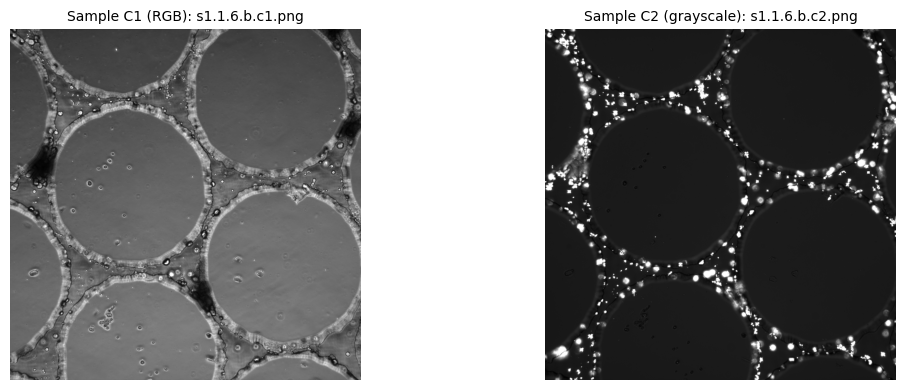

In [3]:
# =======================
# Section 3: Discover images (from GitHub repo) + preview samples
# =======================

import re
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Paths inside the GitHub repo
INPUT_ROOT = Path("test_images")
OUT_ROOT   = Path("results")
MODEL_DIR  = Path("model")

# Create required folders
OUT_ROOT.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("Working directory:", Path.cwd())
print("INPUT_ROOT:", INPUT_ROOT.resolve())
print("MODEL_DIR:", MODEL_DIR.resolve())
print("OUT_ROOT:", OUT_ROOT.resolve())

# Confirm input exists
if not INPUT_ROOT.exists():
    raise FileNotFoundError(
        f"Could not find INPUT_ROOT: {INPUT_ROOT.resolve()}\n"
        "Fix: confirm you committed images to test_images/ in GitHub."
    )

# Find all image files recursively
valid_ext = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
all_imgs = sorted([p for p in INPUT_ROOT.rglob("*") if p.suffix.lower() in valid_ext])

# Detect C1 and C2 from filename
c1_files = sorted([p for p in all_imgs if ".c1." in p.name.lower() or p.name.lower().endswith(".c1.png")])
c2_files = sorted([p for p in all_imgs if ".c2." in p.name.lower() or p.name.lower().endswith(".c2.png")])

print(f"Found {len(all_imgs)} total image files")
print(f"Found {len(c1_files)} C1 images")
print(f"Found {len(c2_files)} C2 images")

if len(c1_files) == 0 or len(c2_files) == 0:
    raise FileNotFoundError(
        "No C1/C2 files detected.\n"
        "Expected filenames to contain '.c1.' and '.c2.' (example: t2.1.8.c.c1.png)."
    )

# -----------------------
# Preview helpers
# -----------------------
def read_c1_rgb_uint8(path: Path) -> np.ndarray:
    """
    Read C1 as RGB uint8 (H,W,3).
    This matches the model training assumption: in_channels=3.
    """
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # Handle rare case where image is 16-bit stored in 3 channels (normalize to uint8)
    if rgb.dtype == np.uint16:
        rgb = (rgb / 256).astype(np.uint8)
    elif rgb.dtype != np.uint8:
        rgb = cv2.normalize(rgb, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return rgb

def read_c2_gray_uint8(path: Path) -> np.ndarray:
    """
    Read C2 as grayscale uint8 (H,W).
    """
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")

    # Convert to grayscale if needed
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize types
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)
    elif img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img

# -----------------------
# Show sample images (C1 and C2)
# -----------------------
sample_c1 = c1_files[0]
sample_c2 = c2_files[0]

c1_img_rgb = read_c1_rgb_uint8(sample_c1)
c2_img = read_c2_gray_uint8(sample_c2)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(c1_img_rgb)
plt.title(f"Sample C1 (RGB): {sample_c1.name}", fontsize=10)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(c2_img, cmap="gray")
plt.title(f"Sample C2 (grayscale): {sample_c2.name}", fontsize=10)
plt.axis("off")

plt.tight_layout()
plt.show()


Current working directory: /content/micropillar-precipitation-segmentation
INPUT_ROOT: /content/micropillar-precipitation-segmentation/test_images
MODEL_DIR: /content/micropillar-precipitation-segmentation/model
OUT_ROOT: /content/micropillar-precipitation-segmentation/results

Folder check passed.
test_images exists: True
model exists: True
results exists: True


In [7]:
# =======================
# Section 4: Load U-Net model weights (manual Box download + inline upload)
# =======================

from pathlib import Path
import torch
import segmentation_models_pytorch as smp

# Self-contained device selection
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Expected model location inside the repo
MODEL_PATH = Path("model/pillar_unet.pt")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

BOX_LINK = "https://cornell.box.com/s/4dyu78bhtpabm98jgz40gdp5wmoe71xn"

# If the model does not exist, require user to download from Box and upload via the Colab button
if not MODEL_PATH.exists():
    print("Model weights are required to run this notebook.\n")
    print("Step A: Download the model file from Box in your browser:")
    print(f"  {BOX_LINK}\n")
    print("Step B: Upload the downloaded .pt file using the Colab file picker.\n")

    try:
        from google.colab import files  # only available in Colab
        uploaded = files.upload()       # user picks the .pt file here
    except Exception as e:
        raise FileNotFoundError(
            "Model file is missing, and inline upload is only supported when running in Google Colab.\n\n"
            f"Expected model path:\n  {MODEL_PATH.resolve()}\n\n"
            "Fix:\n"
            "1) Download the .pt file from Box\n"
            "2) Upload it into this runtime (Colab recommended)\n"
            "3) Re-run this cell\n\n"
            f"Original error:\n{e}"
        )

    # Choose the uploaded .pt file (largest .pt if multiple)
    uploaded_pt = [Path(fn) for fn in uploaded.keys() if fn.lower().endswith(".pt")]
    if len(uploaded_pt) == 0:
        raise FileNotFoundError(
            "No .pt file was uploaded.\n"
            "Please re-run the cell and upload the model weights file ending in .pt."
        )

    uploaded_pt = sorted(uploaded_pt, key=lambda p: p.stat().st_size, reverse=True)
    chosen = uploaded_pt[0]

    # Move/rename into repo/model/
    chosen.replace(MODEL_PATH)

    print("\nModel file saved to:")
    print(f"  {MODEL_PATH.resolve()}\n")

else:
    print("Model file found:")
    print(f"  {MODEL_PATH.resolve()}\n")

# -----------------------
# Define model architecture (must match training)
# -----------------------
# IMPORTANT: this checkpoint expects 3-channel input (RGB)
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)

# -----------------------
# Load checkpoint
# -----------------------
ckpt = torch.load(MODEL_PATH, map_location="cpu", weights_only=False)
state = ckpt["state_dict"] if (isinstance(ckpt, dict) and "state_dict" in ckpt) else ckpt

# Remove "model." prefix if present
clean_state = {}
for k, v in state.items():
    k2 = k[len("model."):] if k.startswith("model.") else k
    clean_state[k2] = v

missing, unexpected = model.load_state_dict(clean_state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model = model.to(DEVICE)
model.eval()

print("Model loaded and ready.")


Using device: cpu
Model weights are required to run this notebook.

Step A: Download the model file from Box in your browser:
  https://cornell.box.com/s/4dyu78bhtpabm98jgz40gdp5wmoe71xn

Step B: Upload the downloaded .pt file using the Colab file picker.



Saving unet_pillars_trained.pt to unet_pillars_trained.pt

Model file saved to:
  /content/micropillar-precipitation-segmentation/model/pillar_unet.pt

Missing keys: []
Unexpected keys: []
Model loaded and ready.


In [7]:
# =======================
# Section 5: Run pillar inference on all images + save outputs + preview a saved result
# =======================

import pandas as pd
import numpy as np
import cv2
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

# Safety: ensure required globals exist
if "INPUT_ROOT" not in globals():
    INPUT_ROOT = Path("test_images")
if "OUT_ROOT" not in globals():
    OUT_ROOT = Path("results")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# Pairing logic: match by removing ".c1." / ".c2." token
def pair_c1_c2(c1_files, c2_files):
    c2_map = {}
    for p in c2_files:
        key = p.name.replace(".c2.", ".")
        c2_map[key] = p

    pairs = []
    for c1 in c1_files:
        key = c1.name.replace(".c1.", ".")
        pairs.append((c1, c2_map.get(key)))
    return pairs

def parse_filename(fname: str):
    # Expected example: t2.1.8.c.c1.png
    # channel=t2, section=1, diameter=8, trial=c, modality=c1
    stem = Path(fname).name
    stem = re.sub(r"\.(png|jpg|jpeg|tif|tiff)$", "", stem, flags=re.IGNORECASE)
    parts = stem.split(".")
    out = {"channel": None, "section": None, "diameter": None, "trial": None, "modality": None}

    for token in parts[::-1]:
        if token.lower() in ("c1", "c2"):
            out["modality"] = token.lower()
            break

    if len(parts) >= 5:
        out["channel"]  = parts[0]
        out["section"]  = parts[1]
        out["diameter"] = parts[2]
        out["trial"]    = parts[3]
    return out

def save_mask_png(mask01: np.ndarray, out_path: Path) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_path), (mask01.astype(np.uint8) * 255))

# Re-discover files from INPUT_ROOT
valid_ext = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
all_imgs = sorted([p for p in INPUT_ROOT.rglob("*") if p.suffix.lower() in valid_ext])

c1_files = sorted([p for p in all_imgs if ".c1." in p.name.lower() or p.name.lower().endswith(".c1.png")])
c2_files = sorted([p for p in all_imgs if ".c2." in p.name.lower() or p.name.lower().endswith(".c2.png")])

pairs = pair_c1_c2(c1_files, c2_files)

MASK_DIR = OUT_ROOT / "pillar_masks"
MASK_DIR.mkdir(parents=True, exist_ok=True)

print("Using INPUT_ROOT:", INPUT_ROOT.resolve())
print("Saving masks to:", MASK_DIR.resolve())
print("Pairs to process:", len(pairs))

if len(pairs) == 0:
    raise RuntimeError("No C1/C2 pairs found. Check test_images filenames.")

mask_index = []

for c1_path, c2_path in tqdm(pairs, desc="Pillar inference"):
    c1 = read_gray_uint8(c1_path)
    mask01 = infer_pillar_mask(c1)

    # Save mask with consistent naming: <original>.mask.png
    out_mask_path = MASK_DIR / (c1_path.name.replace(".c1.", ".c1.") + ".mask.png")
    out_mask_path = out_mask_path.with_name(c1_path.stem + ".mask.png")

    save_mask_png(mask01, out_mask_path)

    meta = parse_filename(c1_path.name)
    mask_index.append({
        "c1_path": str(c1_path),
        "c2_path": str(c2_path) if c2_path is not None else None,
        "mask_path": str(out_mask_path),
        **meta
    })

mask_index_df = pd.DataFrame(mask_index)
mask_index_csv = OUT_ROOT / "mask_index.csv"
mask_index_df.to_csv(mask_index_csv, index=False)

print("Saved mask index:", mask_index_csv.resolve())
print(f"Saved {len(mask_index_df)} pillar masks")

# Preview a saved result (first one)
row0 = mask_index_df.iloc[0]
c1_preview = read_gray_uint8(Path(row0["c1_path"]))
m_preview  = read_gray_uint8(Path(row0["mask_path"])) > 0

overlay = cv2.cvtColor(c1_preview, cv2.COLOR_GRAY2BGR)
overlay[m_preview] = (0, 0, 255)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(c1_preview, cmap="gray")
plt.title(f"C1: {Path(row0['c1_path']).name}", fontsize=10)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Saved mask overlay: {Path(row0['mask_path']).name}", fontsize=10)
plt.axis("off")

plt.tight_layout()
plt.show()

mask_index_df.head()


Using device: cpu

❌ Model file not found at: models/pillar_unet.pt

✅ Upload your model weights now (this will open a file picker in Colab)...


Saving unet_pillars_set4_finetuned.pt to unet_pillars_set4_finetuned.pt
✅ Model file saved to: /content/micropillar-precipitation-segmentation/models/pillar_unet.pt
ℹ️ Detected 3-channel encoder.conv1.weight. Converting to 1-channel by averaging RGB weights...
Missing keys: []
Unexpected keys: []
✅ Model loaded and ready.


Using device: cpu
MODEL_PATH: /content/micropillar-precipitation-segmentation/model/pillar_unet.pt
Missing keys: []
Unexpected keys: []
Model loaded and ready.
INPUT_ROOT: /content/micropillar-precipitation-segmentation/test_images
Total image files found: 10
C1 files found: 5


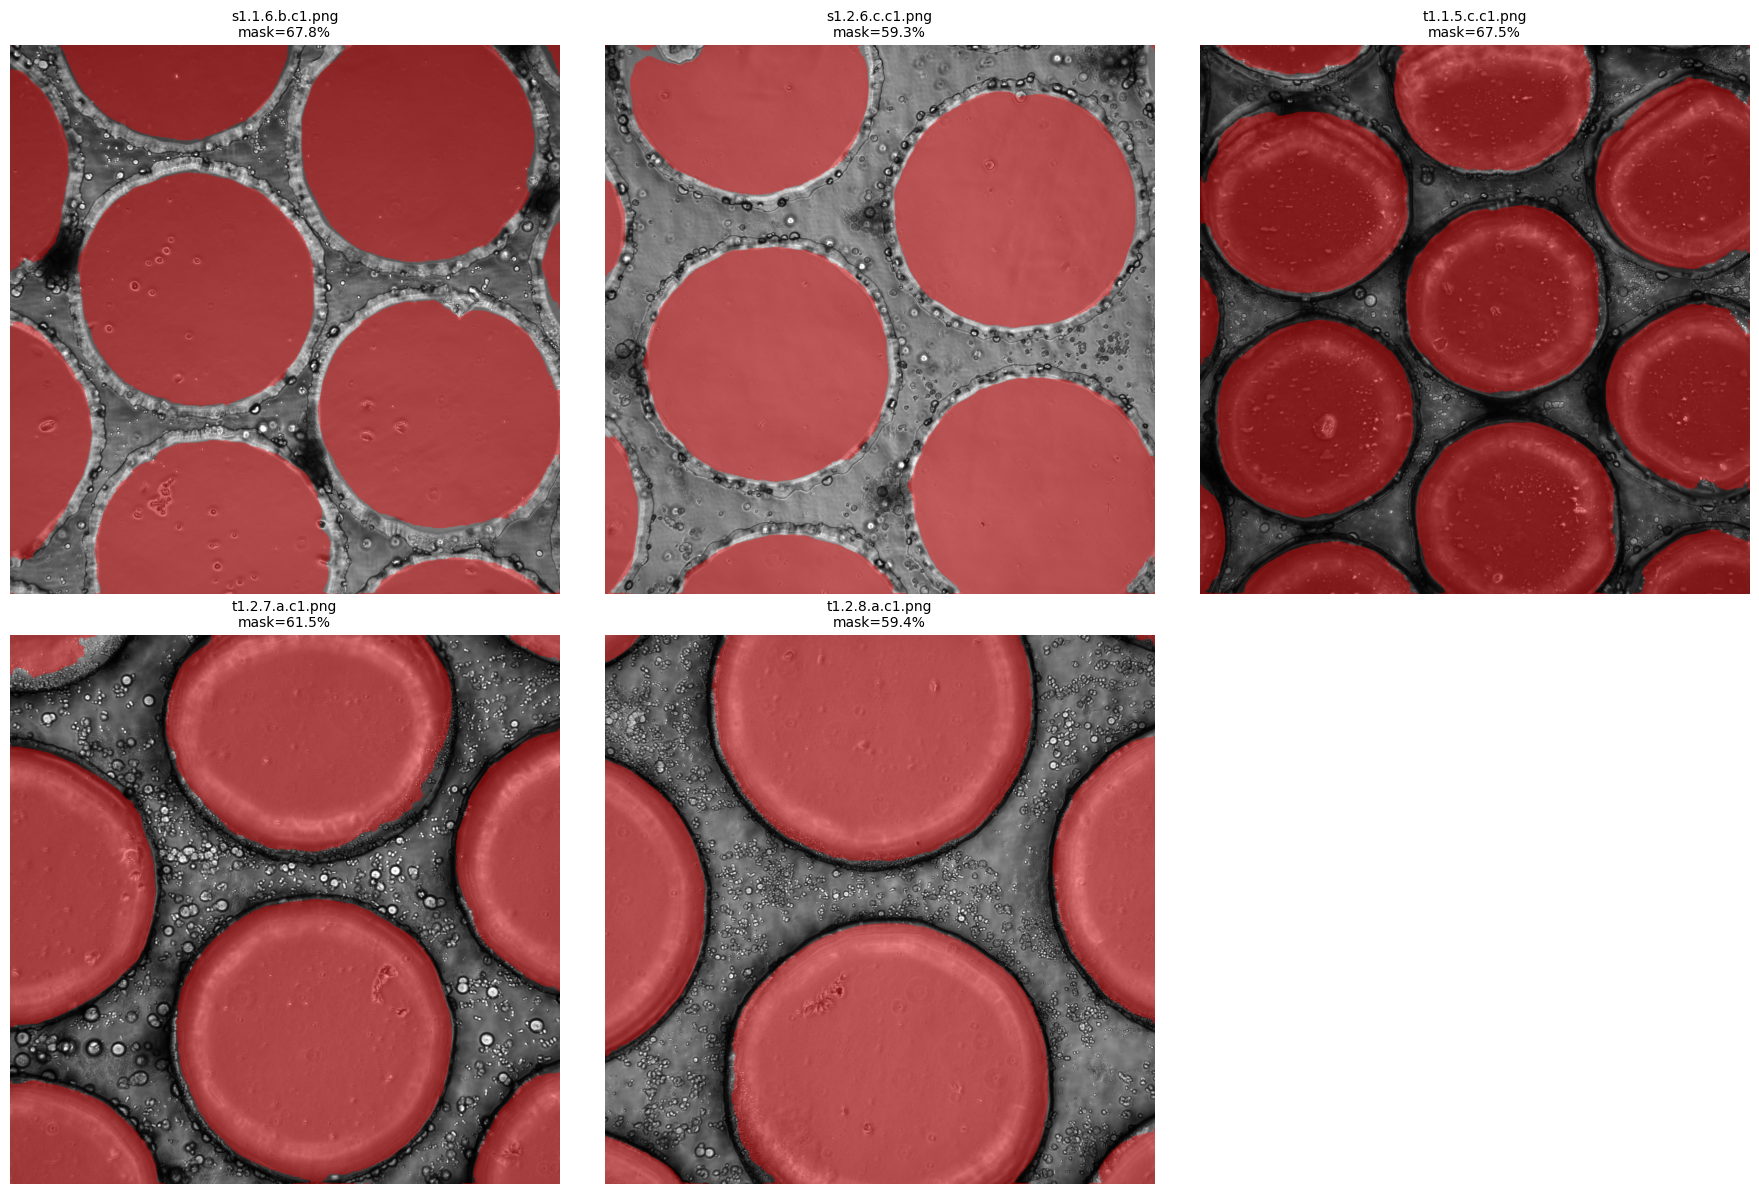

In [13]:
# =======================
# Section 4: Load U-Net model weights + preview mask overlays on ALL C1 images (MATCHES OLD PIPELINE)
# =======================

from pathlib import Path
import re
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2

# -----------------------
# Paths (repo layout)
# -----------------------
INPUT_ROOT = Path("test_images")
MODEL_PATH = Path("model/pillar_unet.pt")
BOX_LINK = "https://cornell.box.com/s/4dyu78bhtpabm98jgz40gdp5wmoe71xn"

if not INPUT_ROOT.exists():
    raise FileNotFoundError(f"Missing INPUT_ROOT: {INPUT_ROOT.resolve()}")

MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

# -----------------------
# Device
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# -----------------------
# If model missing, require inline upload
# -----------------------
if not MODEL_PATH.exists():
    print("Model weights are required to run this notebook.\n")
    print("Step A: Download the model file from Box in your browser:")
    print(BOX_LINK)
    print("\nStep B: Upload the .pt file using the Colab file picker.\n")

    try:
        from google.colab import files
        uploaded = files.upload()
    except Exception as e:
        raise FileNotFoundError(
            "Model file is missing, and inline upload is only supported in Google Colab.\n\n"
            f"Expected model path:\n  {MODEL_PATH.resolve()}\n\n"
            "Fix:\n"
            "1) Download the .pt file from Box\n"
            "2) Upload it into this runtime\n"
            "3) Re-run this cell\n\n"
            f"Original error:\n{e}"
        )

    uploaded_pt = [Path(fn) for fn in uploaded.keys() if fn.lower().endswith(".pt")]
    if len(uploaded_pt) == 0:
        raise FileNotFoundError(
            "No .pt file was uploaded.\n"
            "Re-run the cell and upload the model weights file ending in .pt."
        )

    chosen = sorted(uploaded_pt, key=lambda p: p.stat().st_size, reverse=True)[0]
    chosen.replace(MODEL_PATH)

print("MODEL_PATH:", MODEL_PATH.resolve())

# -----------------------
# Config
# -----------------------
VALID_EXT = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}
SHORT_SIDE = 768
THR = 0.50
KERNEL = np.ones((5, 5), np.uint8)

def read_rgb_uint8(path: Path) -> np.ndarray:
    """
    Read image as RGB uint8 (0..255), preserving true pixel scale.
    """
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")

    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)
    elif img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def resize_short_rgb(im: np.ndarray, short_side: int = SHORT_SIDE) -> np.ndarray:
    h, w = im.shape[:2]
    scale = short_side / min(h, w)
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))
    return cv2.resize(im, (new_w, new_h), interpolation=cv2.INTER_AREA)

# -----------------------
# Load checkpoint robustly
# -----------------------
ckpt = torch.load(MODEL_PATH, map_location="cpu", weights_only=False)
state = ckpt["state_dict"] if (isinstance(ckpt, dict) and "state_dict" in ckpt) else ckpt

clean_state = {}
for k, v in state.items():
    k2 = k[len("model."):] if k.startswith("model.") else k
    clean_state[k2] = v

# -----------------------
# Build model as 3-channel (do NOT average conv1)
# -----------------------
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)

missing, unexpected = model.load_state_dict(clean_state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model = model.to(DEVICE)
model.eval()
print("Model loaded and ready.")

# -----------------------
# Inference (MATCHES YOUR OLD WORKING INPUT SCALE)
# -----------------------
@torch.no_grad()
def infer_pillar_mask_from_rgb(rgb_u8: np.ndarray) -> np.ndarray:
    """
    Returns 0/1 mask at original resolution.
    IMPORTANT: input tensor is float but in 0..255 scale (same as old code).
    """
    H, W = rgb_u8.shape[:2]

    rs = resize_short_rgb(rgb_u8, SHORT_SIDE)

    # EXACT old behavior:
    # ToTensorV2 makes CHW tensor in 0..255 range, then .float()
    x_t = ToTensorV2()(image=rs)["image"].unsqueeze(0).to(DEVICE).float()

    logits = model(x_t)
    prob = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()

    prob_full = cv2.resize(prob, (W, H), interpolation=cv2.INTER_LINEAR)

    pred01 = (prob_full > THR).astype(np.uint8)
    pred01 = (cv2.morphologyEx(pred01 * 255, cv2.MORPH_OPEN, KERNEL, iterations=1) > 0).astype(np.uint8)
    pred01 = (cv2.morphologyEx(pred01 * 255, cv2.MORPH_CLOSE, KERNEL, iterations=1) > 0).astype(np.uint8)

    return pred01

def overlay_red(rgb_u8: np.ndarray, mask01: np.ndarray, alpha: float = 0.40) -> np.ndarray:
    base = rgb_u8.astype(np.float32)
    red = np.zeros_like(base)
    red[..., 0] = 255.0
    m = (mask01 > 0).astype(np.float32)[..., None]
    out = base * (1 - alpha * m) + red * (alpha * m)
    return np.clip(out, 0, 255).astype(np.uint8)

# -----------------------
# Discover C1 files
# -----------------------
all_imgs = sorted([p for p in INPUT_ROOT.rglob("*") if p.suffix.lower() in VALID_EXT])
c1_files = sorted([p for p in all_imgs if ".c1." in p.name.lower() or p.name.lower().endswith(".c1.png")])

print("INPUT_ROOT:", INPUT_ROOT.resolve())
print("Total image files found:", len(all_imgs))
print("C1 files found:", len(c1_files))

if len(c1_files) == 0:
    raise FileNotFoundError("No C1 images found. Expected names like: t2.1.8.c.c1.png")

# -----------------------
# Show overlay for ALL C1 images
# -----------------------
overlays = []
titles = []

for p in c1_files:
    rgb = read_rgb_uint8(p)
    mask01 = infer_pillar_mask_from_rgb(rgb)
    cov = 100.0 * mask01.mean()
    overlays.append(overlay_red(rgb, mask01, alpha=0.40))
    titles.append(f"{p.name}\nmask={cov:.1f}%")

cols = 3
rows = int(np.ceil(len(overlays) / cols))

plt.figure(figsize=(6 * cols, 6 * rows))
for i, (img, t) in enumerate(zip(overlays, titles), start=1):
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(t, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


INPUT_ROOT: /content/micropillar-precipitation-segmentation/test_images
MASK_ROOT: /content/micropillar-precipitation-segmentation/results/pillar_masks
INDEX_CSV: /content/micropillar-precipitation-segmentation/results/mask_index.csv
Using DEVICE: cpu
Total image files found: 10
Total C1 found: 5


Saving pillar masks:   0%|          | 0/5 [00:00<?, ?it/s]


Saved masks: 5
Skipped (already existed): 0
Wrote: /content/micropillar-precipitation-segmentation/results/mask_index.csv


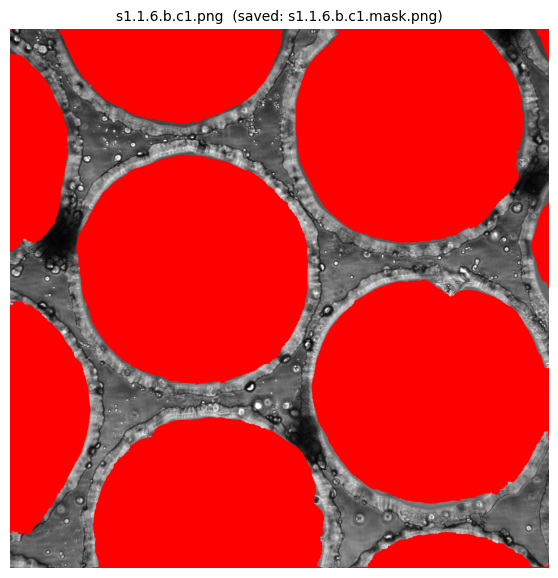

In [15]:
# =======================
# Section 6: Save pillar masks for ALL C1 images (writes results/pillar_masks + results/mask_index.csv)
# =======================

import re
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# -----------------------
# Paths (repo layout)
# -----------------------
INPUT_ROOT = Path("test_images")
OUT_ROOT   = Path("results")
MASK_ROOT  = OUT_ROOT / "pillar_masks"
INDEX_CSV  = OUT_ROOT / "mask_index.csv"

OUT_ROOT.mkdir(parents=True, exist_ok=True)
MASK_ROOT.mkdir(parents=True, exist_ok=True)

if not INPUT_ROOT.exists():
    raise FileNotFoundError(f"Missing INPUT_ROOT: {INPUT_ROOT.resolve()}")

# -----------------------
# Require model from Section 4
# -----------------------
if "model" not in globals():
    raise NameError("Model not found in globals. Run Section 4 first to load the U-Net model.")
if "DEVICE" not in globals():
    DEVICE = "cuda" if cv2.cuda.getCudaEnabledDeviceCount() > 0 else "cpu"

print("INPUT_ROOT:", INPUT_ROOT.resolve())
print("MASK_ROOT:", MASK_ROOT.resolve())
print("INDEX_CSV:", INDEX_CSV.resolve())
print("Using DEVICE:", DEVICE)

# -----------------------
# Config (match your old inference style)
# -----------------------
SHORT_SIDE = 768
THR = 0.50
OVERWRITE = True   # set False if you want to keep existing masks

KERNEL = np.ones((5, 5), np.uint8)
VALID_EXT = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

def resize_short(im: np.ndarray, short: int = SHORT_SIDE) -> np.ndarray:
    """Resize image so min(H,W) == short while preserving aspect ratio."""
    h, w = im.shape[:2]
    s = short / min(h, w)
    return cv2.resize(im, (int(round(w * s)), int(round(h * s))), interpolation=cv2.INTER_AREA)

def read_rgb_uint8(img_path: Path) -> np.ndarray:
    """Read image as RGB uint8 (H,W,3)."""
    bgr = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")

    # If grayscale, convert to 3-channel
    if bgr.ndim == 2:
        bgr = cv2.cvtColor(bgr, cv2.COLOR_GRAY2BGR)

    # If 16-bit, downscale
    if bgr.dtype == np.uint16:
        bgr = (bgr / 256).astype(np.uint8)
    elif bgr.dtype != np.uint8:
        bgr = cv2.normalize(bgr, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    return rgb

def find_matching_c2(c1_path: Path) -> Path | None:
    """Match C2 by swapping '.c1.' -> '.c2.' in filename (same folder)."""
    name = c1_path.name
    name2 = name.lower()
    if ".c1." in name2:
        c2_name = re.sub(r"\.c1\.", ".c2.", name, flags=re.IGNORECASE)
        c2_path = c1_path.with_name(c2_name)
        return c2_path if c2_path.exists() else None
    return None

# albumentations ToTensorV2 import (same as your old pipeline)
from albumentations.pytorch import ToTensorV2
import torch

@torch.no_grad()
def infer_mask01_from_rgb(rgb_uint8: np.ndarray) -> np.ndarray:
    """
    Run U-Net, return mask01 uint8 {0,1} at original resolution.
    IMPORTANT: uses your old pipeline:
      RGB -> resize_short -> ToTensorV2 -> sigmoid -> resize back -> thr -> morph
    """
    H, W = rgb_uint8.shape[:2]

    rs = resize_short(rgb_uint8, SHORT_SIDE)
    ten = ToTensorV2()(image=rs)["image"].unsqueeze(0).to(DEVICE).float()

    prob = torch.sigmoid(model(ten))[0, 0].detach().cpu().numpy()
    prob_full = cv2.resize(prob, (W, H), interpolation=cv2.INTER_LINEAR)

    mask01 = (prob_full > THR).astype(np.uint8)

    # morph clean (on 0/255)
    m255 = mask01 * 255
    m255 = cv2.morphologyEx(m255, cv2.MORPH_OPEN,  KERNEL, iterations=1)
    m255 = cv2.morphologyEx(m255, cv2.MORPH_CLOSE, KERNEL, iterations=1)
    mask01 = (m255 > 0).astype(np.uint8)
    return mask01

def save_mask(mask01: np.ndarray, out_path: Path) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_path), (mask01.astype(np.uint8) * 255))

# -----------------------
# Discover files
# -----------------------
all_imgs = sorted([p for p in INPUT_ROOT.rglob("*") if p.suffix.lower() in VALID_EXT])
c1_files = sorted([p for p in all_imgs if ".c1." in p.name.lower() or p.name.lower().endswith(".c1.png")])

print("Total image files found:", len(all_imgs))
print("Total C1 found:", len(c1_files))

if len(c1_files) == 0:
    raise FileNotFoundError(
        f"No C1 images found under {INPUT_ROOT.resolve()}.\n"
        "Expected filenames like: t2.1.8.c.c1.png"
    )

# -----------------------
# Run inference + save masks + write index CSV
# -----------------------
rows = []
saved = 0
skipped = 0

for c1_path in tqdm(c1_files, desc="Saving pillar masks"):
    c2_path = find_matching_c2(c1_path)

    out_mask_path = MASK_ROOT / f"{c1_path.stem}.mask.png"

    if out_mask_path.exists() and not OVERWRITE:
        skipped += 1
        rows.append({
            "c1_path": str(c1_path),
            "c2_path": str(c2_path) if c2_path is not None else None,
            "mask_path": str(out_mask_path),
            "threshold": THR
        })
        continue

    rgb = read_rgb_uint8(c1_path)
    mask01 = infer_mask01_from_rgb(rgb)

    save_mask(mask01, out_mask_path)
    saved += 1

    rows.append({
        "c1_path": str(c1_path),
        "c2_path": str(c2_path) if c2_path is not None else None,
        "mask_path": str(out_mask_path),
        "threshold": THR
    })

df_index = pd.DataFrame(rows)
df_index.to_csv(INDEX_CSV, index=False)

print("\nSaved masks:", saved)
print("Skipped (already existed):", skipped)
print("Wrote:", INDEX_CSV.resolve())

# -----------------------
# Quick sanity preview: show ONE saved overlay (mask on raw)
# -----------------------
row0 = df_index.iloc[0]
c1p = Path(row0["c1_path"])
mp  = Path(row0["mask_path"])

rgb0 = read_rgb_uint8(c1p)
m01  = (cv2.imread(str(mp), cv2.IMREAD_GRAYSCALE) > 0).astype(np.uint8)

overlay = rgb0.copy()
overlay[m01 > 0] = (255, 0, 0)  # red fill in RGB

plt.figure(figsize=(7, 7))
plt.imshow(overlay)
plt.title(f"{c1p.name}  (saved: {mp.name})", fontsize=10)
plt.axis("off")
plt.show()


INPUT_ROOT: /content/micropillar-precipitation-segmentation/test_images
MASK_ROOT: /content/micropillar-precipitation-segmentation/results/pillar_masks
Total C1 found: 5
Triplets with C2 + saved mask: 5

Storyboard example:
  C1: t1.1.5.c.c1.png
  C2: t1.1.5.c.c2.png
  MASK: t1.1.5.c.c1.mask.png


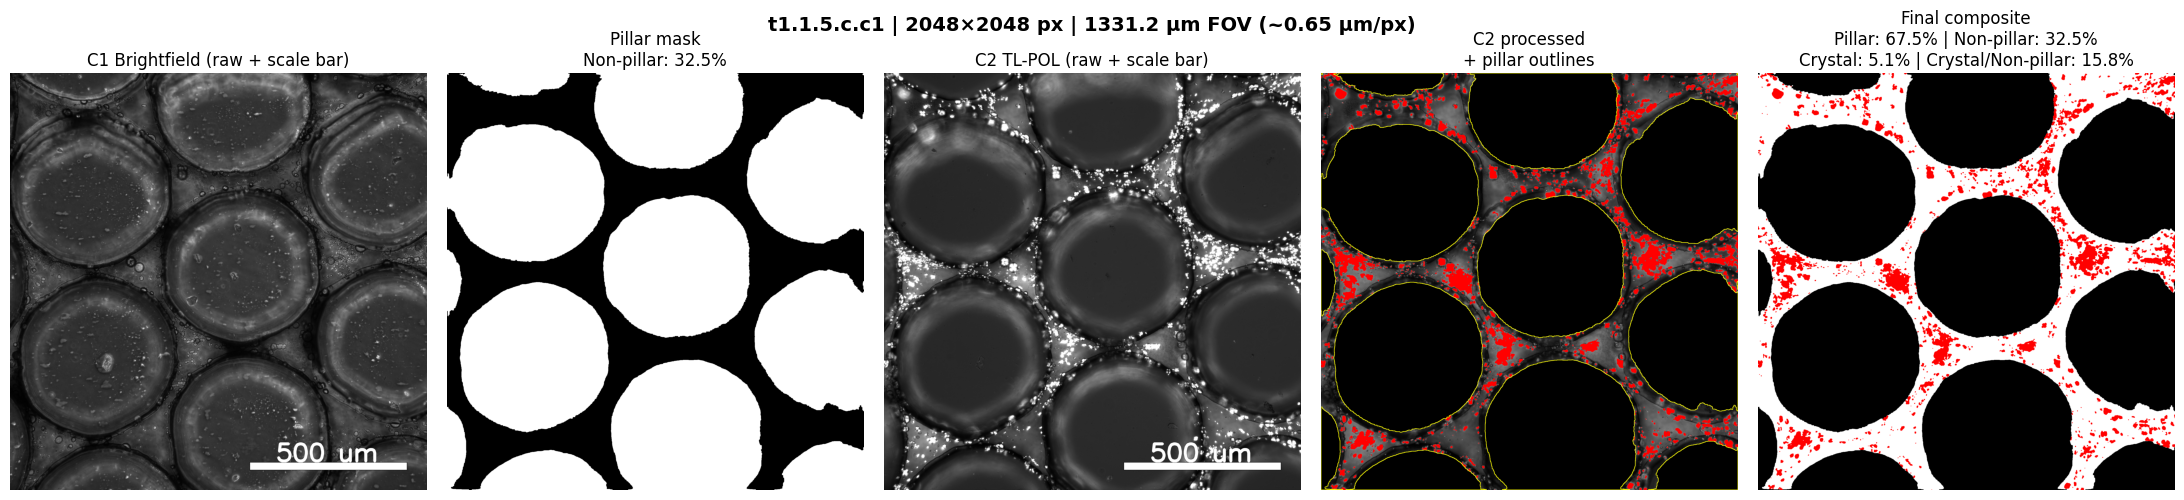

In [20]:
# =======================
# Section 7: Storyboard (random example) with matched C1 + saved pillar mask + C2 processing + metrics
# =======================

import os, glob, random, re
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------
# Paths (repo layout)
# -----------------------
INPUT_ROOT = Path("test_images")
OUT_ROOT   = Path("results")
MASK_ROOT  = OUT_ROOT / "pillar_masks"

if not INPUT_ROOT.exists():
    raise FileNotFoundError(f"Missing INPUT_ROOT: {INPUT_ROOT.resolve()}")
if not MASK_ROOT.exists():
    raise FileNotFoundError(
        f"Missing MASK_ROOT: {MASK_ROOT.resolve()}\n\n"
        "Fix: Run Section 6 first to save pillar masks into results/pillar_masks/"
    )

print("INPUT_ROOT:", INPUT_ROOT.resolve())
print("MASK_ROOT:", MASK_ROOT.resolve())

# -----------------------
# Imaging scale (same as your old storyboard)
# -----------------------
FIELD_UM   = 1331.2
IMG_PX     = 2048
um_per_px  = FIELD_UM / IMG_PX

# -----------------------
# Scale bar style
# -----------------------
SCALE_UM      = 500
BAR_THICK_PX  = 35
MARGIN_PX     = 100
FONT          = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE    = 4
FONT_THICK    = 13

# -----------------------
# C2 binarization settings (same as old)
# -----------------------
# Choose ONE mode: "percentile", "fixed", "otsu+"
C2_THRESH_MODE = "fixed"
C2_FIXED       = 130
C2_PERCENTILE  = 94
C2_DELTA       = 15

# -----------------------
# Helpers
# -----------------------
VALID_EXT = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

def is_img_path(p: Path) -> bool:
    return p.suffix.lower() in VALID_EXT

def read_gray_uint8(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)
    elif img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return img

def add_scale_bar(gray_img, um_per_px, scale_um=SCALE_UM,
                  bar_thick_px=BAR_THICK_PX, margin_px=MARGIN_PX):
    rgb = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    h, w = gray_img.shape[:2]
    bar_len_px = int(round(scale_um / um_per_px))
    bar_len_px = min(bar_len_px, w - 2 * margin_px - 1)

    x2 = w - margin_px
    x1 = x2 - bar_len_px
    y2 = h - margin_px
    y1 = y2 - bar_thick_px

    outline_pad = 2
    cv2.rectangle(rgb, (x1 - outline_pad, y1 - outline_pad),
                  (x2 + outline_pad, y2 + outline_pad), (0, 0, 0), -1)
    cv2.rectangle(rgb, (x1, y1), (x2, y2), (255, 255, 255), -1)

    label = f"{scale_um:.0f} um"
    (tw, th), _ = cv2.getTextSize(label, FONT, FONT_SCALE, FONT_THICK)
    tx = x1 + (bar_len_px - tw) // 2
    ty = y1 - 8

    cv2.putText(rgb, label, (tx, ty), FONT, FONT_SCALE, (0, 0, 0),
                FONT_THICK + 2, cv2.LINE_AA)
    cv2.putText(rgb, label, (tx, ty), FONT, FONT_SCALE, (255, 255, 255),
                FONT_THICK, cv2.LINE_AA)
    return rgb

def find_matching_c2(c1_path: Path) -> Path | None:
    name = c1_path.name
    if re.search(r"\.c1\.", name, flags=re.IGNORECASE):
        c2_name = re.sub(r"\.c1\.", ".c2.", name, flags=re.IGNORECASE)
        c2_path = c1_path.with_name(c2_name)
        return c2_path if c2_path.exists() else None
    return None

def mask_path_for_c1(c1_path: Path) -> Path:
    # Section 6 naming: results/pillar_masks/<c1_stem>.mask.png
    return MASK_ROOT / f"{c1_path.stem}.mask.png"

def to_u8(img: np.ndarray) -> np.ndarray:
    if img.dtype == np.uint8:
        return img
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def binarize_c2(C2_raw: np.ndarray, nonpillar_mask01: np.ndarray) -> np.ndarray:
    """
    Return binary crystal mask (uint8 0/255), conservative thresholding.
    nonpillar_mask01 is uint8 {0,1}.
    """
    img = to_u8(C2_raw)
    roi = cv2.bitwise_and(img, img, mask=(nonpillar_mask01 * 255))
    blur = cv2.GaussianBlur(roi, (3, 3), 0)

    if C2_THRESH_MODE == "fixed":
        thr_val = int(C2_FIXED)
        _, thr = cv2.threshold(blur, thr_val, 255, cv2.THRESH_BINARY)

    elif C2_THRESH_MODE == "percentile":
        vals = blur[nonpillar_mask01 > 0]
        thr_val = int(np.percentile(vals, C2_PERCENTILE)) if vals.size else 255
        _, thr = cv2.threshold(blur, thr_val, 255, cv2.THRESH_BINARY)

    else:  # "otsu+"
        t0, _ = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thr_val = int(max(0, min(255, t0 + C2_DELTA)))
        _, thr = cv2.threshold(blur, thr_val, 255, cv2.THRESH_BINARY)

    thr[nonpillar_mask01 == 0] = 0
    k = np.ones((3, 3), np.uint8)
    thr = cv2.morphologyEx(thr, cv2.MORPH_OPEN,  k, iterations=1)
    thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, k, iterations=1)
    return thr

# -----------------------
# Pick a random VALID triplet (C1 + C2 + saved mask)
# -----------------------
all_imgs = sorted([p for p in INPUT_ROOT.rglob("*") if is_img_path(p)])
c1_files = sorted([p for p in all_imgs if ".c1." in p.name.lower() or p.name.lower().endswith(".c1.png")])

triplets = []
for c1 in c1_files:
    c2 = find_matching_c2(c1)
    mp = mask_path_for_c1(c1)
    if (c2 is not None) and mp.exists():
        triplets.append((c1, c2, mp))

print("Total C1 found:", len(c1_files))
print("Triplets with C2 + saved mask:", len(triplets))

if len(triplets) == 0:
    example_missing = []
    for c1 in c1_files[:5]:
        c2 = find_matching_c2(c1)
        mp = mask_path_for_c1(c1)
        example_missing.append((c1.name, mp.exists(), c2 is not None))
    raise FileNotFoundError(
        "Could not find any (C1, C2, saved mask) triplets.\n\n"
        "Expected:\n"
        "  - C2 exists for each C1 (same name except .c2.)\n"
        "  - mask exists at: results/pillar_masks/<c1_stem>.mask.png\n\n"
        f"Examples (c1_name, mask_exists, c2_exists):\n  {example_missing}\n\n"
        "Fix:\n"
        "  1) Run Section 6 to save masks\n"
        "  2) Ensure masks were written to results/pillar_masks/"
    )

c1_path, c2_path, mask_path = random.choice(triplets)
print("\nStoryboard example:")
print("  C1:", c1_path.name)
print("  C2:", c2_path.name)
print("  MASK:", mask_path.name)

# -----------------------
# Load images
# -----------------------
C1_raw  = read_gray_uint8(c1_path)
C2_raw  = read_gray_uint8(c2_path)
C1_mask = read_gray_uint8(mask_path)

# Ensure mask is aligned
if C1_mask.shape != C2_raw.shape:
    C1_mask = cv2.resize(C1_mask, (C2_raw.shape[1], C2_raw.shape[0]), interpolation=cv2.INTER_NEAREST)

pillar01   = (C1_mask > 0).astype(np.uint8)
nonpillar01 = (pillar01 == 0).astype(np.uint8)

# -----------------------
# Metrics: pillar vs non-pillar
# -----------------------
total_pixels     = int(pillar01.size)
pillar_pixels    = int((pillar01 > 0).sum())
nonpillar_pixels = total_pixels - pillar_pixels
pillar_pct       = 100.0 * pillar_pixels / total_pixels
nonpillar_pct    = 100.0 * nonpillar_pixels / total_pixels

# -----------------------
# C2 processing
# -----------------------
precip = binarize_c2(C2_raw, nonpillar01)

crystal_pixels           = int((precip > 0).sum())
crystal_pct              = 100.0 * crystal_pixels / total_pixels
crystal_in_nonpillar_pct = 100.0 * crystal_pixels / max(1, nonpillar_pixels)

# -----------------------
# Overlays
# -----------------------
proc_rgb = cv2.cvtColor(to_u8(C2_raw), cv2.COLOR_GRAY2RGB)
proc_rgb[precip > 0] = (255, 0, 0)       # crystals red
proc_rgb[pillar01 > 0] = (0, 0, 0)       # pillars black for contrast

overlay = np.zeros_like(proc_rgb)
contours, _ = cv2.findContours((pillar01 > 0).astype(np.uint8),
                               cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlay, contours, -1, (255, 255, 0), 2)  # yellow outlines
proc_with_outline = cv2.addWeighted(proc_rgb, 1.0, overlay, 1.0, 0)

final_rgb = np.zeros_like(proc_rgb)
final_rgb[pillar01 > 0] = (0, 0, 0)
final_rgb[nonpillar01 > 0] = (255, 255, 255)
final_rgb[precip > 0] = (255, 0, 0)

# -----------------------
# Add scale bars to raw views
# -----------------------
C1_with_bar = add_scale_bar(to_u8(C1_raw), um_per_px, SCALE_UM)
C2_with_bar = add_scale_bar(to_u8(C2_raw), um_per_px, SCALE_UM)

# -----------------------
# Plot storyboard
# -----------------------
fig, axes = plt.subplots(1, 5, figsize=(22, 5))

axes[0].imshow(C1_with_bar)
axes[0].set_title("C1 Brightfield (raw + scale bar)")
axes[0].axis("off")

axes[1].imshow(pillar01 * 255, cmap="gray")
axes[1].set_title(f"Pillar mask\nNon-pillar: {nonpillar_pct:.1f}%")
axes[1].axis("off")

axes[2].imshow(C2_with_bar)
axes[2].set_title("C2 TL-POL (raw + scale bar)")
axes[2].axis("off")

axes[3].imshow(proc_with_outline)
axes[3].set_title("C2 processed\n+ pillar outlines")
axes[3].axis("off")

axes[4].imshow(final_rgb)
axes[4].set_title(
    "Final composite\n"
    f"Pillar: {pillar_pct:.1f}% | Non-pillar: {nonpillar_pct:.1f}%\n"
    f"Crystal: {crystal_pct:.1f}% | Crystal/Non-pillar: {crystal_in_nonpillar_pct:.1f}%"
)
axes[4].axis("off")

plt.suptitle(
    f"{c1_path.stem} | {C1_raw.shape[1]}×{C1_raw.shape[0]} px | "
    f"{FIELD_UM:.1f} µm FOV (~{um_per_px:.2f} µm/px)",
    fontsize=14,
    fontweight="bold"
)
plt.tight_layout()
plt.show()


INPUT_ROOT: /content/micropillar-precipitation-segmentation/test_images
MASK_ROOT: /content/micropillar-precipitation-segmentation/results/pillar_masks
Saving storyboards to: /content/micropillar-precipitation-segmentation/results/storyboards
Total C1 found: 5
Triplets with C2 + saved mask: 5

Saved storyboards: 5
Saved metrics: /content/micropillar-precipitation-segmentation/results/storyboard_metrics.csv

Previewing ALL storyboard PNG(s): 5 total



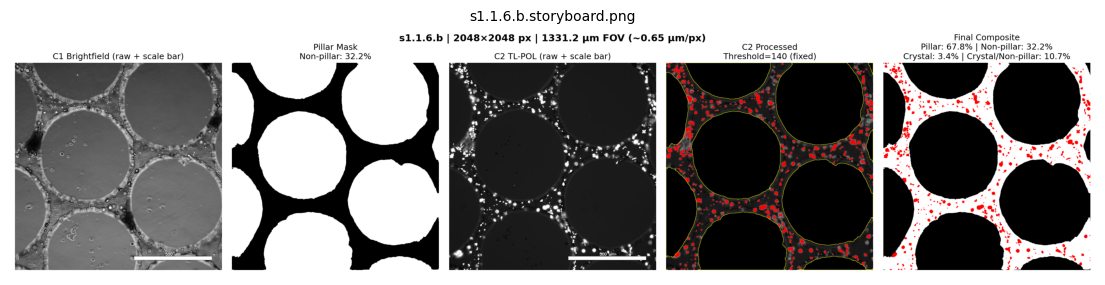

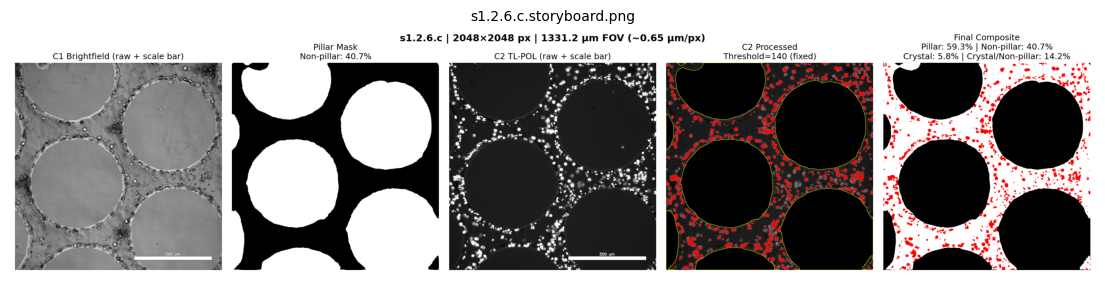

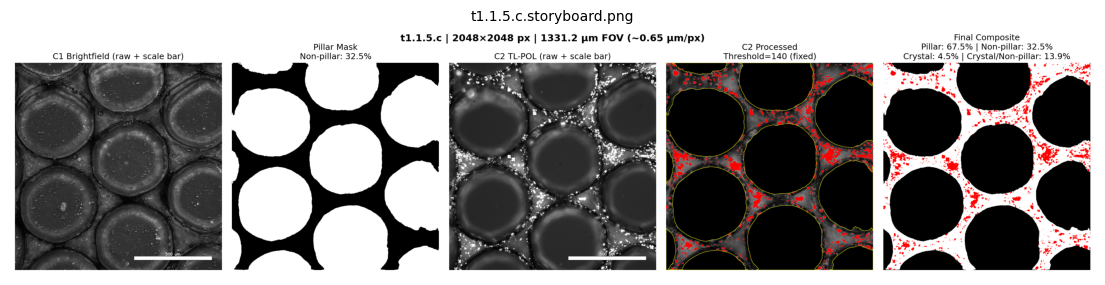

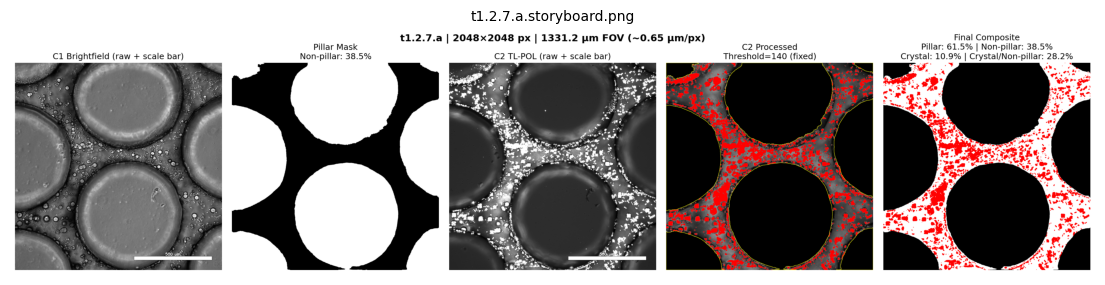

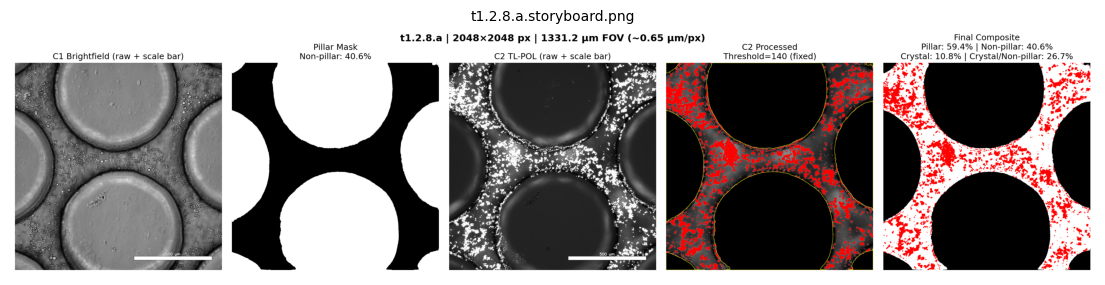

base_key                      c1_path                      c2_path  \
0  s1.1.6.b  test_images/s1.1.6.b.c1.png  test_images/s1.1.6.b.c2.png   
1  s1.2.6.c  test_images/s1.2.6.c.c1.png  test_images/s1.2.6.c.c2.png   
2  t1.1.5.c  test_images/t1.1.5.c.c1.png  test_images/t1.1.5.c.c2.png   
3  t1.2.7.a  test_images/t1.2.7.a.c1.png  test_images/t1.2.7.a.c2.png   
4  t1.2.8.a  test_images/t1.2.8.a.c1.png  test_images/t1.2.8.a.c2.png   

                                   mask_path c2_thresh_mode  c2_thresh_value  \
0  results/pillar_masks/s1.1.6.b.c1.mask.png          fixed              140   
1  results/pillar_masks/s1.2.6.c.c1.mask.png          fixed              140   
2  results/pillar_masks/t1.1.5.c.c1.mask.png          fixed              140   
3  results/pillar_masks/t1.2.7.a.c1.mask.png          fixed              140   
4  results/pillar_masks/t1.2.8.a.c1.mask.png          fixed              140   

   pillar_pixels  nonpillar_pixels  crystal_pixels  pillar_pct_total  \
0        2845787           1348517          143638         67.848849   
1        2486017           1708287          242800         59.271264   
2        2832206           1362098          189184         67.525053   
3        2580595           1613709          455160         61.526179   
4        2493067           1701237          453541         59.439349   

   nonpillar_pct_total  crystal_pct_total  crystal_pct_nonpillar  \
0            32.151151           3.424597              10.651553   
1            40.728736           5.788803              14.213068   
2            32.474947           4.510498              13.889162   
3            38.473821          10.851860              28.205829   
4            40.560651          10.813260              26.659484   

                               storyboard_path  
0  results/storyboards/s1.1.6.b.storyboard.png  
1  results/storyboards/s1.2.6.c.storyboard.png  
2  results/storyboards/t1.1.5.c.storyboard.png  
3  results/storyboards/t1.2.7.a.storyboard.png  
4  results/storyboards/t1.2.8.a.storyboard.png

In [22]:
# =======================
# Section 7: Build storyboards for ALL images (C1 + mask + C2 processing) + save + preview ALL
# =======================

import os
import re
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# -----------------------
# Paths (GitHub repo layout)
# -----------------------
INPUT_ROOT = Path("test_images")
OUT_ROOT   = Path("results")
MASK_ROOT  = OUT_ROOT / "pillar_masks"
STORY_DIR  = OUT_ROOT / "storyboards"

if not INPUT_ROOT.exists():
    raise FileNotFoundError(f"Missing input folder: {INPUT_ROOT.resolve()}")
if not MASK_ROOT.exists():
    raise FileNotFoundError(
        f"Missing mask folder: {MASK_ROOT.resolve()}\n"
        "Run Section 6 first to generate pillar masks."
    )

STORY_DIR.mkdir(parents=True, exist_ok=True)

print("INPUT_ROOT:", INPUT_ROOT.resolve())
print("MASK_ROOT:", MASK_ROOT.resolve())
print("Saving storyboards to:", STORY_DIR.resolve())

# -----------------------
# Imaging scale
# -----------------------
FIELD_UM = 1331.2   # field of view (µm)
IMG_PX   = 2048     # pixels per side
um_per_px = FIELD_UM / IMG_PX

# -----------------------
# Scale bar style
# -----------------------
SCALE_UM     = 500
BAR_THICK_PX = 35
MARGIN_PX    = 100
FONT         = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE   = 1.2
FONT_THICK   = 3

# -----------------------
# C2 binarization settings
# -----------------------
# Choose ONE:
#   "fixed"       : use C2_FIXED
#   "percentile"  : use C2_PERCENTILE
#   "otsu+"       : use Otsu + C2_DELTA
C2_THRESH_MODE = "fixed"

# If C2_THRESH_MODE == "fixed":
C2_FIXED = 140

# If C2_THRESH_MODE == "percentile":
C2_PERCENTILE = 94

# If C2_THRESH_MODE == "otsu+":
C2_DELTA = 15

# Morphology cleanup for C2 precip
C2_MORPH_KERNEL = np.ones((3, 3), np.uint8)

VALID_EXT = {".png", ".jpg", ".jpeg", ".tif", ".tiff"}

# -----------------------
# Helpers
# -----------------------
def read_gray_uint8(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.dtype == np.uint16:
        img = (img / 256).astype(np.uint8)
    elif img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return img

def add_scale_bar(gray_img: np.ndarray, um_per_px: float, scale_um: float = SCALE_UM) -> np.ndarray:
    """Return RGB copy of gray_img with a scale bar."""
    rgb = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
    h, w = gray_img.shape[:2]

    bar_len_px = int(round(scale_um / um_per_px))
    bar_len_px = min(bar_len_px, w - 2 * MARGIN_PX - 1)

    x2 = w - MARGIN_PX
    x1 = x2 - bar_len_px
    y2 = h - MARGIN_PX
    y1 = y2 - BAR_THICK_PX

    outline_pad = 2
    cv2.rectangle(
        rgb,
        (x1 - outline_pad, y1 - outline_pad),
        (x2 + outline_pad, y2 + outline_pad),
        (0, 0, 0),
        -1
    )
    cv2.rectangle(rgb, (x1, y1), (x2, y2), (255, 255, 255), -1)

    label = f"{scale_um:.0f} um"
    (tw, th), _ = cv2.getTextSize(label, FONT, FONT_SCALE, FONT_THICK)
    tx = x1 + (bar_len_px - tw) // 2
    ty = y1 - 10
    ty = max(20, ty)

    cv2.putText(rgb, label, (tx, ty), FONT, FONT_SCALE, (0, 0, 0), FONT_THICK + 2, cv2.LINE_AA)
    cv2.putText(rgb, label, (tx, ty), FONT, FONT_SCALE, (255, 255, 255), FONT_THICK, cv2.LINE_AA)
    return rgb

def to_u8(img: np.ndarray) -> np.ndarray:
    if img.dtype == np.uint8:
        return img
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def binarize_c2(C2_raw: np.ndarray, nonpillar_mask01: np.ndarray) -> tuple[np.ndarray, int]:
    """
    Conservative C2 thresholding restricted to non-pillar region.
    Returns:
      thr_mask (uint8 0/255),
      thr_value (int)
    """
    img = to_u8(C2_raw)

    roi = cv2.bitwise_and(img, img, mask=(nonpillar_mask01.astype(np.uint8) * 255))
    blur = cv2.GaussianBlur(roi, (3, 3), 0)

    if C2_THRESH_MODE == "fixed":
        thr_val = int(C2_FIXED)
        _, thr = cv2.threshold(blur, thr_val, 255, cv2.THRESH_BINARY)

    elif C2_THRESH_MODE == "percentile":
        vals = blur[nonpillar_mask01 > 0]
        thr_val = int(np.percentile(vals, C2_PERCENTILE)) if vals.size else 255
        _, thr = cv2.threshold(blur, thr_val, 255, cv2.THRESH_BINARY)

    else:  # "otsu+"
        t0, _ = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thr_val = int(max(0, min(255, int(t0) + int(C2_DELTA))))
        _, thr = cv2.threshold(blur, thr_val, 255, cv2.THRESH_BINARY)

    thr[nonpillar_mask01 == 0] = 0
    thr = cv2.morphologyEx(thr, cv2.MORPH_OPEN, C2_MORPH_KERNEL, iterations=1)
    thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, C2_MORPH_KERNEL, iterations=1)

    return thr, thr_val

def find_matching_c2(c1_path: Path) -> Path | None:
    """
    Match t2.1.8.c.c1.png -> t2.1.8.c.c2.png
    """
    name = c1_path.name
    c2_name = name.replace(".c1.", ".c2.")
    if c2_name == name:
        # fallback: if unexpected, just try stem replacement
        c2_name = c1_path.stem.replace(".c1", ".c2") + c1_path.suffix

    candidate = c1_path.with_name(c2_name)
    return candidate if candidate.exists() else None

def mask_path_for_c1(c1_path: Path) -> Path:
    """
    Section 6 saved masks as:
      results/pillar_masks/<c1_stem>.mask.png
    Example:
      t2.1.8.c.c1.png -> t2.1.8.c.c1.mask.png
    """
    return MASK_ROOT / f"{c1_path.stem}.mask.png"

# -----------------------
# Discover images
# -----------------------
all_imgs = sorted([p for p in INPUT_ROOT.rglob("*") if p.suffix.lower() in VALID_EXT])

c1_files = sorted([p for p in all_imgs if ".c1." in p.name.lower() or p.name.lower().endswith(".c1.png")])
print("Total C1 found:", len(c1_files))

if len(c1_files) == 0:
    raise FileNotFoundError("No C1 images found. Expected names like: t2.1.8.c.c1.png")

# -----------------------
# Build (C1, C2, mask) triplets
# -----------------------
triplets = []
missing_masks = []
missing_c2 = []

for c1 in c1_files:
    c2 = find_matching_c2(c1)
    mpath = mask_path_for_c1(c1)

    if c2 is None:
        missing_c2.append(c1.name)
        continue
    if not mpath.exists():
        missing_masks.append(c1.name)
        continue

    triplets.append((c1, c2, mpath))

print("Triplets with C2 + saved mask:", len(triplets))

if len(triplets) == 0:
    example_missing = []
    for c1 in c1_files[:10]:
        example_missing.append((c1.name, str(mask_path_for_c1(c1).exists()), str(find_matching_c2(c1) is not None)))

    raise FileNotFoundError(
        "Could not find any (C1, C2, mask) triplets.\n\n"
        "Expected:\n"
        "  - C2 exists for each C1 (same name except .c2.)\n"
        "  - mask exists at: results/pillar_masks/<c1_stem>.mask.png\n\n"
        "Examples (C1 name, mask_exists, c2_exists):\n"
        f"  {example_missing}\n\n"
        "Fix:\n"
        "  1) Re-run Section 6 to generate masks\n"
        "  2) Confirm mask naming is <c1_stem>.mask.png"
    )

# -----------------------
# Build storyboards + metrics for ALL triplets
# -----------------------
metrics_rows = []

for c1_path, c2_path, mask_path in triplets:
    base_key = c1_path.stem.replace(".c1", "")

    # Load raw images + mask
    C1_raw = read_gray_uint8(c1_path)
    C2_raw = read_gray_uint8(c2_path)

    C1_mask = read_gray_uint8(mask_path)
    if C1_mask.shape != C2_raw.shape:
        C1_mask = cv2.resize(C1_mask, (C2_raw.shape[1], C2_raw.shape[0]), interpolation=cv2.INTER_NEAREST)

    pillar01 = (C1_mask > 0).astype(np.uint8)
    nonpillar01 = (pillar01 == 0).astype(np.uint8)

    # Metrics: pillar vs nonpillar
    total_pixels = int(C1_mask.size)
    pillar_pixels = int(pillar01.sum())
    nonpillar_pixels = int(total_pixels - pillar_pixels)

    pillar_pct = 100.0 * pillar_pixels / max(1, total_pixels)
    nonpillar_pct = 100.0 * nonpillar_pixels / max(1, total_pixels)

    # C2 precipitation mask (restricted to nonpillar)
    precip255, thr_val = binarize_c2(C2_raw, nonpillar01)
    precip01 = (precip255 > 0).astype(np.uint8)

    crystal_pixels = int(precip01.sum())
    crystal_pct_total = 100.0 * crystal_pixels / max(1, total_pixels)
    crystal_pct_nonpillar = 100.0 * crystal_pixels / max(1, nonpillar_pixels)

    # Overlays
    proc_rgb = cv2.cvtColor(C2_raw, cv2.COLOR_GRAY2RGB)
    proc_rgb[precip01 > 0] = (255, 0, 0)     # crystals red
    proc_rgb[pillar01 > 0] = (0, 0, 0)       # pillars black

    overlay = np.zeros_like(proc_rgb)
    contours, _ = cv2.findContours(pillar01, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, contours, -1, (255, 255, 0), 2)  # pillar outlines yellow
    proc_with_outline = cv2.addWeighted(proc_rgb, 1.0, overlay, 1.0, 0)

    final_rgb = np.zeros_like(proc_rgb)
    final_rgb[pillar01 > 0] = (0, 0, 0)          # pillars
    final_rgb[nonpillar01 > 0] = (255, 255, 255) # background
    final_rgb[precip01 > 0] = (255, 0, 0)        # crystals

    # Add scale bars
    C1_with_bar = add_scale_bar(C1_raw, um_per_px, SCALE_UM)
    C2_with_bar = add_scale_bar(C2_raw, um_per_px, SCALE_UM)

    # Plot storyboard
    fig, axes = plt.subplots(1, 5, figsize=(22, 5))

    axes[0].imshow(C1_with_bar)
    axes[0].set_title("C1 Brightfield (raw + scale bar)")
    axes[0].axis("off")

    axes[1].imshow(pillar01 * 255, cmap="gray")
    axes[1].set_title(f"Pillar Mask\nNon-pillar: {nonpillar_pct:.1f}%")
    axes[1].axis("off")

    axes[2].imshow(C2_with_bar)
    axes[2].set_title("C2 TL-POL (raw + scale bar)")
    axes[2].axis("off")

    axes[3].imshow(proc_with_outline)
    axes[3].set_title(f"C2 Processed\nThreshold={thr_val} ({C2_THRESH_MODE})")
    axes[3].axis("off")

    axes[4].imshow(final_rgb)
    axes[4].set_title(
        "Final Composite\n"
        f"Pillar: {pillar_pct:.1f}% | Non-pillar: {nonpillar_pct:.1f}%\n"
        f"Crystal: {crystal_pct_total:.1f}% | Crystal/Non-pillar: {crystal_pct_nonpillar:.1f}%"
    )
    axes[4].axis("off")

    plt.suptitle(
        f"{base_key} | {C1_raw.shape[1]}×{C1_raw.shape[0]} px | "
        f"{FIELD_UM:.1f} µm FOV (~{um_per_px:.2f} µm/px)",
        fontsize=14,
        fontweight="bold",
    )

    plt.tight_layout()

    # Save storyboard PNG
    out_png = STORY_DIR / f"{base_key}.storyboard.png"
    fig.savefig(out_png, dpi=150, bbox_inches="tight")
    plt.close(fig)

    metrics_rows.append({
        "base_key": base_key,
        "c1_path": str(c1_path),
        "c2_path": str(c2_path),
        "mask_path": str(mask_path),
        "c2_thresh_mode": C2_THRESH_MODE,
        "c2_thresh_value": int(thr_val),
        "pillar_pixels": pillar_pixels,
        "nonpillar_pixels": nonpillar_pixels,
        "crystal_pixels": crystal_pixels,
        "pillar_pct_total": pillar_pct,
        "nonpillar_pct_total": nonpillar_pct,
        "crystal_pct_total": crystal_pct_total,
        "crystal_pct_nonpillar": crystal_pct_nonpillar,
        "storyboard_path": str(out_png),
    })

# Save metrics table
metrics_df = pd.DataFrame(metrics_rows)
metrics_csv = OUT_ROOT / "storyboard_metrics.csv"
metrics_df.to_csv(metrics_csv, index=False)

print("\nSaved storyboards:", len(metrics_df))
print("Saved metrics:", metrics_csv.resolve())

# -----------------------
# Preview ALL storyboards inline
# -----------------------
print(f"\nPreviewing ALL storyboard PNG(s): {len(metrics_df)} total\n")

for i in range(len(metrics_df)):
    fp = Path(metrics_df.iloc[i]["storyboard_path"])
    img = cv2.imread(str(fp))
    if img is None:
        print("Could not read:", fp)
        continue

    plt.figure(figsize=(14, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(fp.name, fontsize=10)
    plt.axis("off")
    plt.show()

metrics_df.head()
